# The Economic Costs of Earthquakes
### DLP

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

Sectoral shares of GDP: agriculture, administration, construction, education, financial, food, health, information, manufacturing, occupation, professional, public services, rental, retail, transport, wholesale, and others (averaged between 2006 and 2010)


Percentage of the population with a tertiary educational level (averaged between 2007 and 2010)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

CHILE_PLOT_YAXIS_LABEL = 'GDP per Capita (Millions of CLP)'

In [2]:
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest
import sys
sys.path.insert(0, '../src')
import process_chile_gdp_data as pcd

df = pcd.process_data_for_synth()

dataprep = Dataprep(
    foo=df,
    predictors=['agropecuario', 'pesca', 'mineria', 'industria_m',
       'electricidad', 'construccion', 'comercio', 'transporte',
       'servicios_financieros', 'vivienda', 'personales', 'publica'],
    predictors_op="mean",
    time_predictors_prior=range(2005, 2009),
    special_predictors=[
        ("gdp_cap", range(2005, 2009), "mean"),
        ("ed_superior_cap", range(2008, 2009), "mean")
    ],
    dependent="gdp_cap",
    unit_variable="region_name",
    time_variable="year",
    treatment_identifier="VII Del Maule",
    controls_identifier=[
        'I De Tarapacá', 'II De Antofagasta', 'III De Atacama',
       'IV De Coquimbo', 'V De Valparaíso',
       'RMS Región Metropolitana de Santiago',
       'VI Del Libertador General Bernardo OHiggins', 
       'IX De La Araucanía', 'X De Los Lagos',
       'XI Aysén del General Carlos Ibáñez del Campo',
       'XII De Magallanes y de la Antártica Chilena'
    ],
    time_optimize_ssr=range(1990, 2009),
)


We supply the `Dataprep` object to a `Synth` object. The optimisation scheme we use is [Nelder-Mead](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html) and the starting point for the optimisation is `equal` i.e. with all weights equal. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point*.

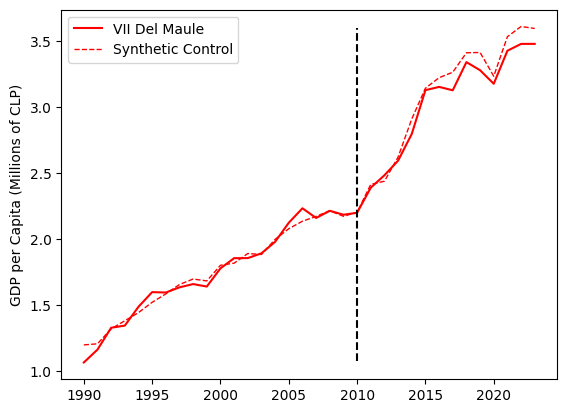

In [3]:
import util
import importlib
from matplotlib import pyplot as plt
importlib.reload(util)

synth = Synth()
synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="ols")
cl_res = util.synth_plot_chile(synth, time_period=range(1990, 2024), treatment_time=2010, filename='chile_scm1990.png')

In [4]:
cl_res

,Synthetic Control,VII Del Maule
year,,
2000,1.803184e+06,1.779899e+06
2001,1.819408e+06,1.857115e+06
2002,1.892296e+06,1.857540e+06
2003,1.885058e+06,1.893727e+06
2004,1.999300e+06,1.980970e+06
2005,2.080043e+06,2.125212e+06
2006,2.136809e+06,2.234582e+06
2007,2.173265e+06,2.161353e+06
2008,2.216450e+06,2.215648e+06


The synthetic control obtained from the optimisation is: $$\text{Synthetic Control} = 0.851 \times \text{Cataluna} + 0.149 \times \text{Madrid}.$$

The `path_plot` method shows the path of the treated unit and the synthetic control over time.

The `gaps_plot` method shows the gaps (the difference between the treated unit and the synthetic control) over time.

In [5]:
synth.weights()

I De Tarapacá                                   0.000
II De Antofagasta                               0.000
III De Atacama                                  0.000
IV De Coquimbo                                  0.000
V De Valparaíso                                 0.000
RMS Región Metropolitana de Santiago            0.000
VI Del Libertador General Bernardo OHiggins     0.323
IX De La Araucanía                              0.356
X De Los Lagos                                  0.321
XI Aysén del General Carlos Ibáñez del Campo    0.000
XII De Magallanes y de la Antártica Chilena     0.000
Name: weights, dtype: float64

Compute the average treatment effect on the treated unit (ATT) over the post-treatment time period, also returns a standard error (se).

In [6]:
synth.att(time_period=range(2010, 2023))

{'att': -65063.50082635009, 'se': 16019.621860089084}

The summary function gives more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [10]:
synth.summary()

,V,treated,synthetic,sample mean
agropecuario,0.083,0.165,0.138,0.057
pesca,0.017,0.000,0.041,0.041
mineria,0.724,0.005,0.034,0.162
industria_m,0.001,0.218,0.140,0.131
electricidad,0.001,0.089,0.024,0.024
construccion,0.001,0.077,0.091,0.088
comercio,0.027,0.059,0.105,0.094
transporte,0.000,0.104,0.100,0.095
servicios_financieros,0.021,0.072,0.091,0.097
vivienda,0.126,0.056,0.058,0.053


We can run a Placebo test using the `PlaceboTest` class. After instantiating it, we supply the original `Dataprep` object to it as well as a synthetic control method object (our `synth` from previously) and any options that we want to supply to the synthetic control method object (the optimisation scheme and starting point for the optimisation scheme).

In [7]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "ols"},
)

(1/11) Completed placebo test for IV De Coquimbo.
(2/11) Completed placebo test for II De Antofagasta.
(3/11) Completed placebo test for I De Tarapacá.
(4/11) Completed placebo test for III De Atacama.
(5/11) Completed placebo test for V De Valparaíso.
(6/11) Completed placebo test for RMS Región Metropolitana de Santiago.
(7/11) Completed placebo test for IX De La Araucanía.
(8/11) Completed placebo test for VI Del Libertador General Bernardo OHiggins.
(9/11) Completed placebo test for XII De Magallanes y de la Antártica Chilena.
(10/11) Completed placebo test for X De Los Lagos.
(11/11) Completed placebo test for XI Aysén del General Carlos Ibáñez del Campo.
Calculating treated unit gaps.
Done.


We can plot the gaps for the treated unit as well as all the placebos in one graph using the `gaps_plot` method of the `PlaceboTest` class. We can refine the gaps plot by removing those placebos that did not have a good pre-treatment match, namely we can remove from the plot any placebo whose pre-treatment mean-square prediction error is $> n\, \times $ the pre-treatment mean-square prediction error of the treated unit. The following graph is a refined version of the previous with $n=1$ (`mspe_threshold=1`).

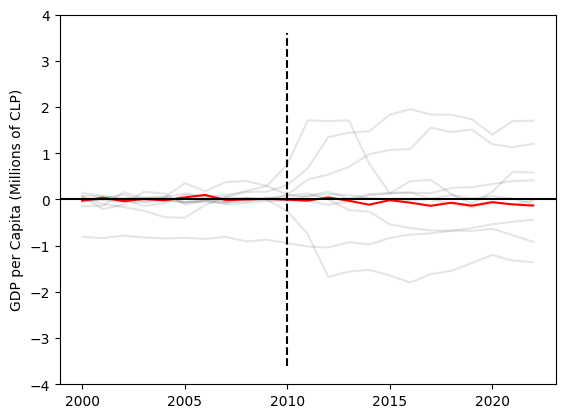

In [13]:
import util
importlib.reload(util)
util.placebo_plot(placebo_test, time_period=range(2000, 2023), mspe_threshold=100, treatment_time=2010,
    divide_by=1000000, y_axis_limit=4, y_axis_label=CHILE_PLOT_YAXIS_LABEL, filename='chile_placebo.png')

We calculate $p$-value of Abadie et al's version of Fisher's exact hypothesis test for no effect of treatment null using the `pvalue` method.

In [8]:
placebo_test.pvalue(treatment_time=2010)

0.6666666666666666

We can calculate 95% confidence intervals for the treatment effect for the time periods $t=1976, 1977$. (For technical reasons involving permutation tests, we need to use all the pre-intervention time periods here rather than just the period 1960-1970 where the optimisation was carried out if we want a significance level of $\alpha=0.05$).

**(The following cell can take a while to run.)**

In [20]:
synth.confidence_interval(
    alpha=0.20,
    time_periods=[2010, 2011],
    pre_periods=list(range(2000, 2009)),
    tol=0.01,
    verbose=False,
)

#### Robustness test - Jacknife - Leave out highest weighted region (IX Araucania)

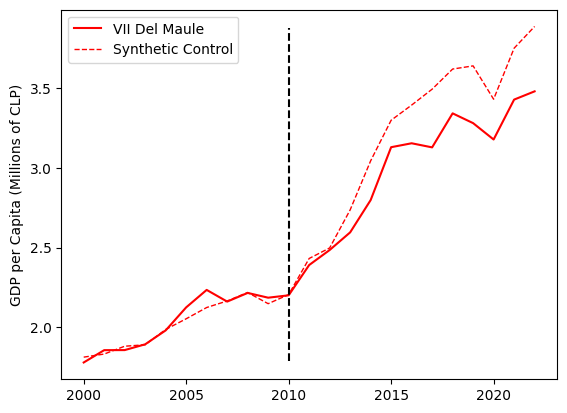

In [23]:
dataprep = Dataprep(
    foo=df,
    predictors=['agropecuario', 'pesca', 'mineria', 'industria_m',
       'electricidad', 'construccion', 'comercio', 'transporte',
       'servicios_financieros', 'vivienda', 'personales', 'publica'],
    predictors_op="mean",
    time_predictors_prior=range(2005, 2009),
    special_predictors=[
        ("gdp_cap", range(2005, 2009), "mean"),
        ("ed_superior_cap", range(2008, 2009), "mean")
    ],
    dependent="gdp_cap",
    unit_variable="region_name",
    time_variable="year",
    treatment_identifier="VII Del Maule",
    controls_identifier=[
        'I De Tarapacá', 'II De Antofagasta', 
       'IV De Coquimbo', 'V De Valparaíso',
       'RMS Región Metropolitana de Santiago', 'IX De La Araucanía',
       'X De Los Lagos', 
       'XI Aysén del General Carlos Ibáñez del Campo',
       'XII De Magallanes y de la Antártica Chilena'
    ],
    time_optimize_ssr=range(1990, 2009),
)

synth_jacknife = Synth()
synth_jacknife.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="ols")
cl_res = util.synth_plot_chile(synth_jacknife, time_period=range(2000, 2023), treatment_time=2010, filename='chile_jacknife.png')

### Sectorial SCM - Construction, Financial and Insurance Services, Agriculture, Manufacturing

In [3]:
import pandas as pd

df = pd.read_csv('../data/scm_2010.csv')
df.head()

,nom_region,year,pib,population,gdp_pc,administración pública,agropecuario-silvícola,"comercio, restaurantes y hoteles",construcción,"electricidad, gas, agua y gestión de desechos",...,construccion,electricidad,industria,mineria,pesca_pct,vivienda,financieros,personales,transporte,id
0,tarapaca,1985,1167.1,2.976439e+05,22.125885,12.541161,0.987887,9.043351,5.876043,1.759133,...,1.300127,0.389224,3.401347,1.266387,10.920875,1.491305,0.921671,2.729063,1.887333,1
1,antofagasta,1985,3481.6,3.692258e+05,30.403342,5.952741,0.105621,4.559122,4.460887,1.174223,...,1.356259,0.357003,1.724174,17.421632,1.095336,1.776011,1.124421,2.388500,1.918699,2
2,atacama,1985,592.7,1.989444e+05,13.637791,12.754017,2.267631,4.563678,6.996993,1.691280,...,0.954235,0.230653,0.760615,6.074502,1.146655,1.280400,1.065807,2.217687,0.966088,3
3,coquimbo,1985,846.9,4.523120e+05,8.981185,12.786034,5.981811,7.834321,10.194809,4.434350,...,0.915615,0.398257,0.550997,1.094577,0.842525,1.371284,0.446466,1.971704,0.636548,4
4,valparaiso,1985,3587.2,1.266195e+06,15.094454,11.381456,3.230699,5.791304,6.844429,3.309335,...,1.033129,0.499526,5.718543,1.033970,0.265434,1.465438,1.136963,2.067649,0.815985,5


In [8]:
df['nom_region'] = df['nom_region'].replace('maule', 'VII del Maule')

Index(['nom_region', 'year', 'pib', 'population', 'gdp_pc',
       'administración pública', 'agropecuario-silvícola',
       'comercio, restaurantes y hoteles', 'construcción',
       'electricidad, gas, agua y gestión de desechos',
       'industria manufacturera', 'minería', 'pesca',
       'servicios de vivienda e inmobiliarios',
       'servicios financieros y empresariales', 'servicios personales',
       'transporte, información y comunicaciones',
       'producto interno bruto pct', 'adm_publica', 'agropecuario', 'comercio',
       'construccion', 'electricidad', 'industria', 'mineria', 'pesca_pct',
       'vivienda', 'financieros', 'personales', 'transporte', 'id'],
      dtype='object')

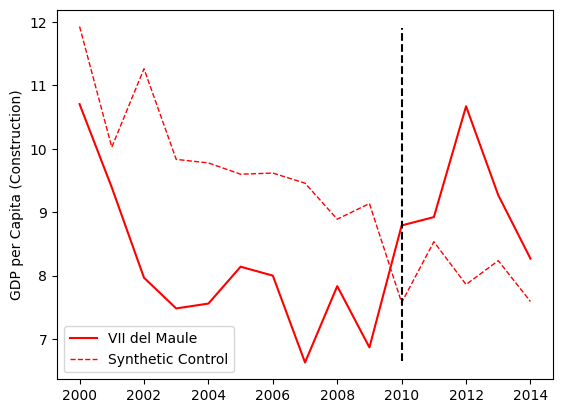

In [21]:
import importlib
import util
importlib.reload(util)

#df = pcd.process_data_for_synth()
df = pd.read_csv('../data/scm_2010.csv')
df['nom_region'] = df['nom_region'].replace('maule', 'VII del Maule')
sectors_to_analyze = ['construcción', 'agropecuario-silvícola', 'servicios financieros y empresariales', 'industria manufacturera']
dct = {'construcción': 'Construction', 'agropecuario-silvícola': 'Agricultural and Silvicultural', 'servicios financieros y empresariales': 'Finance', 'industria manufacturera': 'Manufacturing'}
all_sectors = ['agropecuario-silvícola',
       'comercio, restaurantes y hoteles', 'construcción',
       'electricidad, gas, agua y gestión de desechos',
       'industria manufacturera', 'minería', 'pesca',
       'servicios de vivienda e inmobiliarios',
       'servicios financieros y empresariales', 'servicios personales',
       'transporte, información y comunicaciones']
res = {}
for variable in sectors_to_analyze:
    predictors_lst = [var for var in all_sectors if var != variable]
    dataprep = Dataprep(
    foo=df,
    predictors=predictors_lst,
    predictors_op="mean",
    time_predictors_prior=range(2005, 2009),
    special_predictors=[
        ("gdp_pc", range(2005, 2009), "mean"),
        #("ed_superior_cap", range(2008, 2009), "mean")
    ],
    dependent=variable,
    unit_variable="nom_region",
    time_variable="year",
    treatment_identifier='VII del Maule',
    controls_identifier=[
        'tarapaca', 'antofagasta', 'atacama', 'coquimbo', 'valparaiso',
       'metropolitana', 'ohiggins', 'biobio', 'araucania',
       'loslagos', 'aysen', 'magallanes'
    ],
    time_optimize_ssr=range(1985, 2009),
)
    synth = Synth()
    synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="ols")
    chile_res = util.synth_plot_sector(synth, time_period=range(2000, 2015), treatment_time=2010, filename=f'chile_scm_{dct[variable]}.png', sector=dct[variable])
    res[variable] = chile_res.copy(deep=True)

In [23]:
import pandas as pd

with pd.ExcelWriter('../output/chile_sectorial.xlsx', engine='xlsxwriter') as writer:
    for sheet_name, sheet_data in res.items():
        # Convert the dictionary data to a DataFrame
        df = pd.DataFrame(sheet_data)
        # Write the DataFrame to a specific sheet
        df.to_excel(writer, sheet_name=sheet_name.split()[0], index=True)